<ipython-input-2-f1bb8c2f2676>:427: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(['' for _ in range(len(data['df_sorted']))])
<ipython-input-2-f1bb8c2f2676>:428: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_yticklabels(['' for _ in range(len(data['df_sorted']))])
<ipython-input-2-f1bb8c2f2676>:475: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.97])


Original dataset has 35 studies
Number of unique (x,y) coordinates: 15


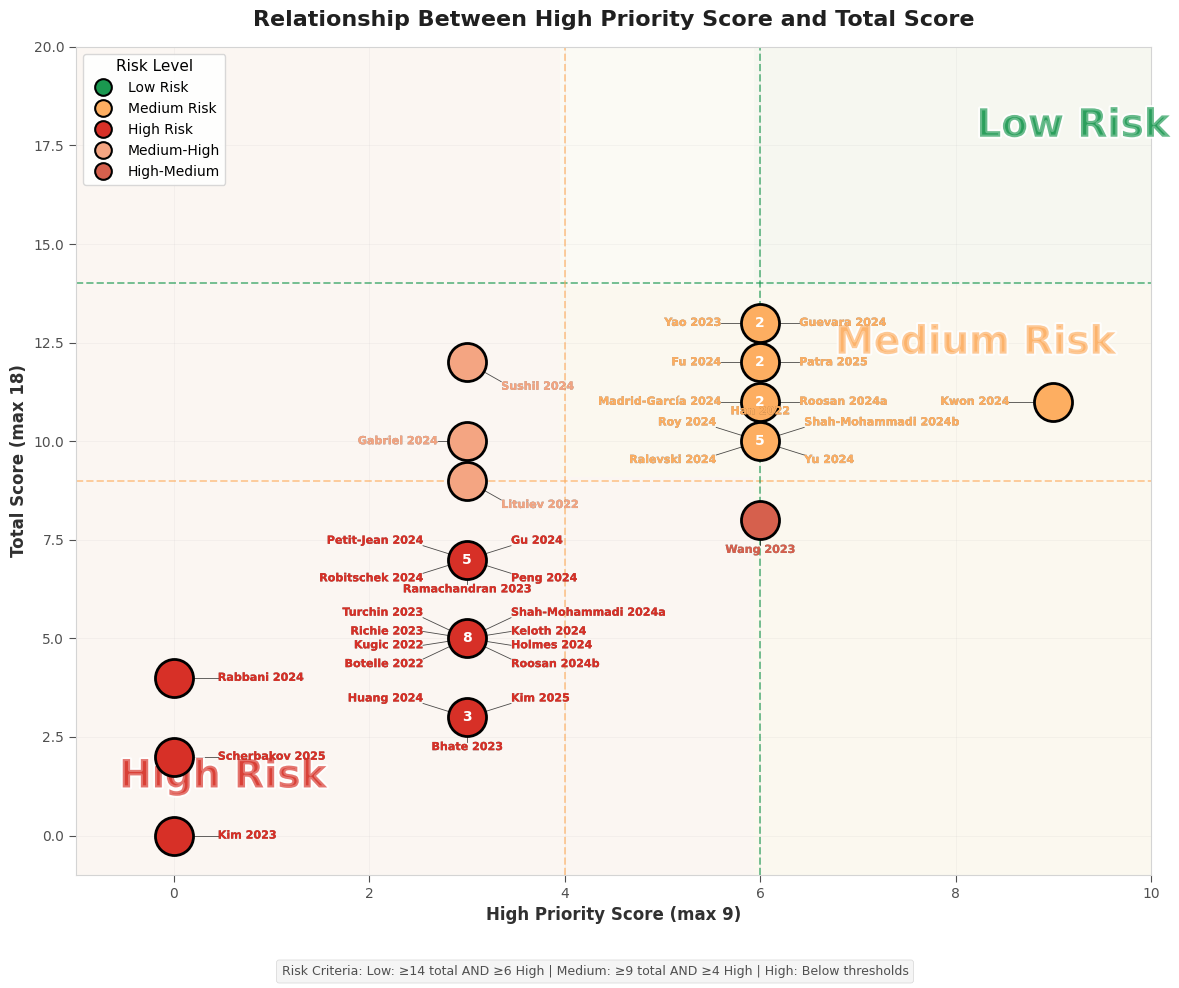

All visualizations have been generated successfully.


In [2]:
# Import necessary libraries
import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Install adjustText if not available
try:
    from adjustText import adjust_text
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "adjustText"])
    from adjustText import adjust_text

#########################################
# CONFIGURATION AND STYLING
#########################################

class PlotStyle:
    """Class to manage plot styling and color palettes"""

    def __init__(self):
        self.color_palette = {
            'High Risk': '#e41a1c',     # Bright red (Nature standard)
            'Medium Risk': '#ff9900',   # Orange (Nature standard)
            'Low Risk': '#4daf4a',      # Green (Nature standard)
            'primary_blue': '#377eb8',  # Nature standard blue
            'secondary_blue': '#80b1d3', # Lighter blue
            'light_blue': '#deebf7',    # Very light blue
            'background': '#ffffff',    # White background
            'grid': '#e6e6e6',          # Light gray grid
            'text': '#3c3c3c',          # Dark gray text
            'accent1': '#984ea3',       # Purple (Nature standard)
            'accent2': '#a65628',       # Brown (Nature standard)
            'accent3': '#f781bf'        # Pink (Nature standard)
        }

        self.risk_cmap = self._create_risk_colormap()
        self._set_plot_parameters()

    def _create_risk_colormap(self):
        """Create colormap from red to yellow to green for heatmaps"""
        return LinearSegmentedColormap.from_list(
            'risk_cmap',
            [(0.0, self.color_palette['High Risk']),
             (0.5, self.color_palette['Medium Risk']),
             (1.0, self.color_palette['Low Risk'])],
            N=100
        )

    def _set_plot_parameters(self):
        """Set global matplotlib parameters for Nature style"""
        plt.rcParams.update({
            'axes.titlesize': 9,
            'axes.titleweight': 'bold',
            'axes.labelsize': 8,
            'xtick.labelsize': 7,
            'ytick.labelsize': 7,
            'legend.fontsize': 7,
            'figure.facecolor': self.color_palette['background'],
            'axes.facecolor': self.color_palette['background'],
            'figure.figsize': (3.5, 2.5),
            'axes.grid': False,
            'grid.color': self.color_palette['grid'],
            'grid.alpha': 0.5,
            'axes.linewidth': 0.5,
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'savefig.dpi': 300,
            'savefig.format': 'pdf',
            'savefig.bbox': 'tight',
            'savefig.transparent': False
        })

#########################################
# DATA PREPARATION
#########################################

class DataProcessor:
    """Class to process and prepare data for visualization"""

    def __init__(self, study_data):
        """
        Initialize with study data dictionary containing:
        - studies: List of study names
        - categories: List of assessment categories
        - priority_levels: List of priority levels for each category
        - max_points: List of maximum points for each category
        - scores: Dictionary of scores for each category
        """
        self.study_data = study_data
        self.processed_data = self._process_data()

    def _process_data(self):
        """Process the raw data into a structured format"""
        # Convert to DataFrame
        df = pd.DataFrame(self.study_data['scores'])
        df['Study'] = self.study_data['studies']

        # Extract risk matrix
        risk_matrix = np.array(df[self.study_data['categories']])

        # Group categories by priority level
        high_priority_indices = [i for i, level in enumerate(self.study_data['priority_levels']) if level == "High"]
        medium_priority_indices = [i for i, level in enumerate(self.study_data['priority_levels']) if level == "Medium"]
        standard_priority_indices = [i for i, level in enumerate(self.study_data['priority_levels']) if level == "Standard"]

        # Calculate scores
        high_priority_scores = risk_matrix[:, high_priority_indices].sum(axis=1)
        medium_priority_scores = risk_matrix[:, medium_priority_indices].sum(axis=1)
        standard_priority_scores = risk_matrix[:, standard_priority_indices].sum(axis=1)
        total_scores = risk_matrix.sum(axis=1)

        # Determine risk levels based on framework criteria
        risk_levels = []
        for i in range(len(self.study_data['studies'])):
            if (total_scores[i] >= 14 and high_priority_scores[i] >= 6 and medium_priority_scores[i] >= 3):
                risk_levels.append("Low Risk")
            elif (total_scores[i] >= 9 and high_priority_scores[i] >= 4 and medium_priority_scores[i] >= 2):
                risk_levels.append("Medium Risk")
            else:
                risk_levels.append("High Risk")

        # Add calculated values to DataFrame
        df["High Priority Score"] = high_priority_scores
        df["Medium Priority Score"] = medium_priority_scores
        df["Standard Priority Score"] = standard_priority_scores
        df["Total Score"] = total_scores
        df["Risk Level"] = risk_levels

        # Calculate maximum possible scores
        max_high_priority = sum([self.study_data['max_points'][i] for i in high_priority_indices])
        max_medium_priority = sum([self.study_data['max_points'][i] for i in medium_priority_indices])
        max_standard_priority = sum([self.study_data['max_points'][i] for i in standard_priority_indices])
        max_total = sum(self.study_data['max_points'])

        # Create normalized matrix for visualization
        normalized_matrix = np.zeros((len(df), len(self.study_data['categories'])))
        for i, cat in enumerate(self.study_data['categories']):
            normalized_matrix[:, i] = df[cat].values / self.study_data['max_points'][i]

        # Sort studies by total score
        df_sorted = df.sort_values(by="Total Score", ascending=False)

        # Create normalized matrix for sorted data
        sorted_normalized_matrix = np.zeros((len(df_sorted), len(self.study_data['categories'])))
        for i, cat in enumerate(self.study_data['categories']):
            sorted_normalized_matrix[:, i] = df_sorted[cat].values / self.study_data['max_points'][i]

        return {
            'df': df,
            'df_sorted': df_sorted,
            'risk_matrix': risk_matrix,
            'normalized_matrix': normalized_matrix,
            'sorted_normalized_matrix': sorted_normalized_matrix,
            'categories': self.study_data['categories'],
            'studies': self.study_data['studies'],
            'priority_levels': self.study_data['priority_levels'],
            'max_points': self.study_data['max_points'],
            'high_priority_indices': high_priority_indices,
            'medium_priority_indices': medium_priority_indices,
            'standard_priority_indices': standard_priority_indices,
            'max_high_priority': max_high_priority,
            'max_medium_priority': max_medium_priority,
            'max_standard_priority': max_standard_priority,
            'max_total': max_total
        }

#########################################
# VISUALIZATION FUNCTIONS
#########################################

class Visualizer:
    """Class containing all visualization functions"""

    def __init__(self, style):
        self.style = style

    def plot_domain_completion(self, data):
        """Creates stacked bar chart of domain completion rates"""
        plt.figure(figsize=(6.5, 3.5), facecolor=self.style.color_palette['background'])

        # Calculate completion percentage for each domain
        completion_percent = []
        for i, cat in enumerate(data['categories']):
            total_points = data['df'][cat].sum()
            max_possible_points = data['max_points'][i] * len(data['studies'])
            percent = (total_points / max_possible_points) * 100
            completion_percent.append(percent)

        # Create DataFrame for stacked bar
        df_stacked = pd.DataFrame({
            'Domain': data['categories'],
            'Completion (%)': completion_percent,
            'Missing (%)': [100 - p for p in completion_percent],
            'Priority': data['priority_levels'],
            'Max Points': data['max_points']
        })

        # Sort by priority level and completion percentage
        priority_order = {"High": 0, "Medium": 1, "Standard": 2}
        df_stacked['Priority Order'] = df_stacked['Priority'].map(priority_order)
        df_stacked = df_stacked.sort_values(['Priority Order', 'Completion (%)'], ascending=[True, False])

        # Create stacked bars
        plt.barh(df_stacked['Domain'], df_stacked['Completion (%)'],
            color=self.style.color_palette['Low Risk'], label='Complete', alpha=0.8, height=0.6)
        plt.barh(df_stacked['Domain'], df_stacked['Missing (%)'],
            left=df_stacked['Completion (%)'], color=self.style.color_palette['High Risk'],
            label='Missing', alpha=0.8, height=0.6)

        # Add annotations
        for i, (domain, priority, points) in enumerate(zip(df_stacked['Domain'], df_stacked['Priority'], df_stacked['Max Points'])):
            plt.text(101, i, f'{priority} ({points}pts)', va='center', fontsize=6)

        # Add separator lines between priority groups
        priority_groups = df_stacked.groupby('Priority Order')
        cumulative_count = 0
        for name, group in priority_groups:
            if name > 0:  # Don't add a line before the first group
                plt.axhline(y=cumulative_count - 0.5, color='black', linestyle='-', alpha=0.3, linewidth=0.5)
            cumulative_count += len(group)

        # Finalize plot
        plt.xlim(0, 120)
        plt.xlabel('Percentage of Maximum Possible Points (%)', fontsize=8)
        plt.title('Domain Completion Rate by Priority Level', fontsize=9, fontweight='bold')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=7)
        plt.grid(axis='x', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.savefig('domain_completion_by_priority.png', dpi=300, bbox_inches='tight')
        plt.savefig('domain_completion_by_priority.pdf', bbox_inches='tight')
        plt.close()

    def plot_risk_assessment_heatmap(self, data):
        """Creates traffic light visualization with circles sized by domain max points"""
        # Adjust figure dimensions - narrower width, taller height
        combined_fig = plt.figure(figsize=(5, 17), facecolor=self.style.color_palette['background'])

        # Update grid proportions with more height
        grid = plt.GridSpec(2, 21, height_ratios=[20, 1], hspace=0.4)

        # Create subplots with adjusted widths
        ax1 = combined_fig.add_subplot(grid[0, :11])  # Main visualization
        ax2 = combined_fig.add_subplot(grid[0, 12:17])  # Priority scores
        ax3 = combined_fig.add_subplot(grid[0, 19:])  # Total score column
        legend_ax = combined_fig.add_subplot(grid[1, :])  # Legend at bottom
        legend_ax.axis('off')  # Hide axis for legend

        # Significantly increase the y-axis limits to create more space between rows
        num_studies = len(data['df_sorted'])
        y_padding = 0.8  # Greatly increased padding between rows

        # Set up the axes with increased spacing
        ax1.set_xlim(-0.5, len(data['categories'])-0.5)
        ax1.set_ylim(-0.5 - y_padding, num_studies-0.5 + y_padding)

        # Add dotted light grid lines to main visualization
        ax1.set_axisbelow(True)
        ax1.grid(which='both', linestyle=':', linewidth=0.5, color='#cccccc', alpha=0.7)

        # For even more readability - add alternating row shading with increased height
        for i in range(len(data['df_sorted'])):
            if i % 2 == 0:  # Even rows
                ax1.axhspan(i-0.5 - y_padding/2, i+0.5 + y_padding/2, color='#f5f5f5', alpha=0.3, zorder=0)

        # Adjust circle size - INCREASED from previous version
        base_size = 130  # Increased from 110 to make circles slightly bigger

        # Calculate circle sizes based on maximum points
        circle_sizes = {}
        for i, max_p in enumerate(data['max_points']):
            if max_p == 2:
                circle_sizes[i] = base_size * 2  # 2 points get base size * 2
            else:  # max_p == 3
                circle_sizes[i] = base_size * 3  # 3 points get base size * 3

        # Plot circles with size based on domain maximum points (consistent across columns)
        for i, study_idx in enumerate(range(len(data['df_sorted']))):
            for j, category_idx in enumerate(range(len(data['categories']))):
                # Get the normalized value for color
                normalized_value = data['sorted_normalized_matrix'][study_idx, category_idx]
                # Get color from colormap
                color = self.style.risk_cmap(normalized_value)

                # Use pre-calculated size for this domain
                circle_size = circle_sizes[category_idx]

                # Create a circle using scatter plot
                ax1.scatter(j, i, s=circle_size, c=[color], alpha=0.8,
                          edgecolors='white', linewidths=0.5, zorder=2)

        # Create y-axis labels (study names without risk level abbreviation)
        y_labels = data['df_sorted']['Study'].values

        # Set y-axis labels with increased font size
        ax1.set_yticks(range(len(y_labels)))
        ax1.set_yticklabels(y_labels, fontsize=8, rotation=0)
        ax1.tick_params(axis='y', pad=25)

        # Set x-axis labels horizontally with full category names
        ax1.set_xticks(range(len(data['categories'])))

        # Create x-labels - now vertical and on one line with proper point notation
        x_labels = []
        for cat, max_p in zip(data['categories'], data['max_points']):
            # Simplified label format - single line, no breaks
            if cat == "Error Analysis":
                label = "Error Analysis"
            elif cat == "Fairness Assessment":
                label = "Fairness Assessment"
            elif cat == "Dataset Availability":
                label = "Dataset Availability"
            elif cat == "External Validation":
                label = "External Validation"
            elif cat == "Annotation Guidelines":
                label = "Annotation Guidelines"
            elif cat == "Code/Prompt Availability":
                label = "Code/Prompt Availability"
            elif cat == "Medical Condition Specificity":
                label = "Medical Condition"
            else:
                label = cat

            # Add points notation
            x_labels.append(f"{label} ({max_p} pts)")

        # Set vertical x-axis labels with decreased font size
        ax1.set_xticklabels(x_labels, rotation=90, ha='center', va='top', fontsize=8, fontweight='bold')
        ax1.tick_params(axis='x', pad=7)
        ax1.set_title('Domain Scores by Study', fontsize=9, fontweight='bold', pad=15)

        # Set up the axes for the priority scores visualization with increased spacing
        ax2.set_xlim(-0.5, 3-0.5)  # Now only 3 columns (High, Medium, Standard)
        ax2.set_ylim(-0.5 - y_padding, num_studies-0.5 + y_padding)

        # Add dotted light grid lines to priority scores visualization
        ax2.set_axisbelow(True)
        ax2.grid(which='both', linestyle=':', linewidth=0.5, color='#cccccc', alpha=0.7)

        # Set up the axes for the total score visualization
        ax3.set_xlim(-0.5, 0.5)  # Just one column
        ax3.set_ylim(-0.5 - y_padding, num_studies-0.5 + y_padding)

        # Add dotted light grid lines to total score visualization
        ax3.set_axisbelow(True)
        ax3.grid(which='both', linestyle=':', linewidth=0.5, color='#cccccc', alpha=0.7)

        # Add shading to total score column
        ax3.axvspan(-0.5, 0.5, color='#e6e6e6', alpha=0.7, zorder=0)

        # For consistency - add same alternating row shading to both summary sections with increased height
        for i in range(len(data['df_sorted'])):
            if i % 2 == 0:  # Even rows
                ax2.axhspan(i-0.5 - y_padding/2, i+0.5 + y_padding/2, color='#f5f5f5', alpha=0.3, zorder=0)
                ax3.axhspan(i-0.5 - y_padding/2, i+0.5 + y_padding/2, color='#f5f5f5', alpha=0.3, zorder=0)

        # Prepare data for summary visualizations
        summary_data_priorities = np.zeros((len(data['df_sorted']), 3))
        summary_data_priorities[:, 0] = data['df_sorted']['High Priority Score'].values / data['max_high_priority']
        summary_data_priorities[:, 1] = data['df_sorted']['Medium Priority Score'].values / data['max_medium_priority']
        summary_data_priorities[:, 2] = data['df_sorted']['Standard Priority Score'].values / data['max_standard_priority']

        summary_data_total = np.zeros((len(data['df_sorted']), 1))
        summary_data_total[:, 0] = data['df_sorted']['Total Score'].values / data['max_total']

        # Use a larger size for all priority section circles
        priority_circle_size = 290
        total_circle_size = 310  # Slightly larger for total score

        # Plot circles for priority scores
        for i in range(len(data['df_sorted'])):
            for j in range(3):  # 3 columns: High, Medium, Standard
                normalized_value = summary_data_priorities[i, j]
                color = self.style.risk_cmap(normalized_value)

                # Create a circle using scatter plot
                ax2.scatter(j, i, s=priority_circle_size, c=[color], alpha=0.8,
                           edgecolors='white', linewidths=0.5, zorder=2)

                # Add score text inside each circle
                if j == 0:
                    score = data['df_sorted']['High Priority Score'].iloc[i]
                elif j == 1:
                    score = data['df_sorted']['Medium Priority Score'].iloc[i]
                else:  # j == 2
                    score = data['df_sorted']['Standard Priority Score'].iloc[i]

                ax2.text(j, i, str(int(score)), ha='center', va='center', fontsize=6,
                        color='white', fontweight='bold', zorder=3)  # Text on top

        # Plot circles for total score
        for i in range(len(data['df_sorted'])):
            normalized_value = summary_data_total[i, 0]
            color = self.style.risk_cmap(normalized_value)

            # Create a circle using scatter plot
            ax3.scatter(0, i, s=total_circle_size, c=[color], alpha=0.8,
                       edgecolors='white', linewidths=0.5, zorder=2)

            # Add score text inside each circle
            score = data['df_sorted']['Total Score'].iloc[i]
            ax3.text(0, i, str(int(score)), ha='center', va='center', fontsize=6,
                    color='white', fontweight='bold', zorder=3)  # Text on top

        # Make priority scores x-axis labels vertical with decreased font
        ax2.set_xticks(range(3))
        ax2.set_xticklabels([
            f'High Priority ({data["max_high_priority"]})',
            f'Medium Priority ({data["max_medium_priority"]})',
            f'Standard Priority ({data["max_standard_priority"]})'
        ], rotation=90, ha='center', va='top', fontsize=8, fontweight='bold')
        ax2.tick_params(axis='x', pad=7)

        # Set up total score x-axis label
        ax3.set_xticks([0])
        ax3.set_xticklabels([f'Total Score ({data["max_total"]})'],
                             rotation=90, ha='center', va='top', fontsize=8, fontweight='bold')
        ax3.tick_params(axis='x', pad=7)

        # Remove y-axis labels for summary sections
        ax2.set_yticklabels(['' for _ in range(len(data['df_sorted']))])
        ax3.set_yticklabels(['' for _ in range(len(data['df_sorted']))])

        # Set titles for summary sections
        ax2.set_title('Priority Scores', fontsize=9, fontweight='bold', pad=15)
        ax3.set_title('Overall Score', fontsize=9, fontweight='bold', pad=15)

        # Create legend for risk levels and circle sizes
        from matplotlib.lines import Line2D
        risk_legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=self.style.color_palette['Low Risk'],
                  markersize=12, label='Low Risk', markeredgecolor='white', markeredgewidth=0.5),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=self.style.color_palette['Medium Risk'],
                  markersize=12, label='Medium Risk', markeredgecolor='white', markeredgewidth=0.5),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=self.style.color_palette['High Risk'],
                  markersize=12, label='High Risk', markeredgecolor='white', markeredgewidth=0.5)
        ]

        # Create size legend only for the domain section
        size_legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#999999',
                   markersize=np.sqrt(base_size * 2)/2.5, label='2 points',
                   markeredgecolor='white', markeredgewidth=0.5),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='#999999',
                   markersize=np.sqrt(base_size * 3)/2.5, label='3 points',
                   markeredgecolor='white', markeredgewidth=0.5)
        ]

        # Create the combined legend
        all_legend_elements = risk_legend_elements + size_legend_elements
        all_legend_labels = ['Low Risk', 'Medium Risk', 'High Risk', '2 points', '3 points']

        # Add the combined legend with larger font
        legend = legend_ax.legend(all_legend_elements, all_legend_labels,
                               loc='center', fontsize=8, frameon=True,
                               ncol=5, columnspacing=1.0,
                               bbox_to_anchor=(0.5, 0.5))

        # Move the title a bit closer to the plot
        combined_fig.suptitle('Risk of Bias Assessment for LLMs Identifying SDoH',
                             fontsize=12, fontweight='bold', y=0.92)

        # Move criteria text a bit closer to the plot
        criteria_text = """Risk Criteria: Low: ≥14 total AND ≥6 High AND ≥3 Medium points | Medium: ≥9 total AND ≥4 High AND ≥2 Medium points | High: Below thresholds"""
        combined_fig.text(0.5, 0.1, criteria_text, ha='center', fontsize=7,
                        bbox={'facecolor': 'lightgrey', 'alpha': 0.5, 'pad': 5})

        # Adjust layout to better accommodate all elements
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])

        plt.savefig('risk_assessment_heatmap.png', dpi=300, bbox_inches='tight')
        plt.savefig('risk_assessment_heatmap.pdf', bbox_inches='tight')
        plt.close()

    def plot_risk_distribution(self, data):
        """Creates bar chart of risk level distribution"""
        # Count studies in each risk category
        risk_counts = data['df']['Risk Level'].value_counts()

        # Create a complete DataFrame with all risk levels
        all_risk_levels = ['High Risk', 'Medium Risk', 'Low Risk']
        complete_risk_counts = pd.Series(0, index=all_risk_levels)

        # Update with actual counts
        for level in risk_counts.index:
            complete_risk_counts[level] = risk_counts[level]

        # Sort in desired order
        complete_risk_counts = complete_risk_counts.reindex(['High Risk', 'Medium Risk', 'Low Risk'])

        plt.figure(figsize=(3.5, 2.5), facecolor=self.style.color_palette['background'])
        bars = plt.bar(range(len(all_risk_levels)), complete_risk_counts.values,
                       color=[self.style.color_palette[level] for level in all_risk_levels], width=0.6)

        # Add count and percentage labels
        for i, v in enumerate(complete_risk_counts.values):
            if v > 0:
                plt.text(i, v + 0.3, str(int(v)), ha='center', fontweight='bold', fontsize=7)
                percentage = (v / len(data['studies'])) * 100
                plt.text(i, v/2, f"{percentage:.1f}%", ha='center', va='center',
                         color='white', fontweight='bold', fontsize=7)

        plt.ylabel('Number of Studies', fontsize=8)
        plt.title('Distribution of Studies by Risk Level', fontsize=9, fontweight='bold')
        plt.ylim(0, max(complete_risk_counts.values) * 1.2 if max(complete_risk_counts.values) > 0 else 1)
        plt.xticks(range(len(all_risk_levels)), ['High', 'Medium', 'Low'], fontsize=7)
        plt.yticks(fontsize=7)
        plt.tight_layout()
        plt.savefig('risk_level_distribution.png', dpi=300, bbox_inches='tight')
        plt.savefig('risk_level_distribution.pdf', bbox_inches='tight')
        plt.close()

    def plot_risk_by_year(self, data):
        """Creates stacked bar chart of risk levels by publication year"""
        # Extract publication years from study names
        years = []
        for study in data['studies']:
            year_part = study.split()[-1]
            numeric_year = ''.join(c for c in year_part if c.isdigit())
            years.append(int(numeric_year))

        unique_years = sorted(set(years))

        # Calculate risk level distribution by year
        year_risk_data = {}
        for year in unique_years:
            year_indices = [i for i, y in enumerate(years) if y == year]
            year_risk_levels = [data['df']['Risk Level'].iloc[i] for i in year_indices]
            year_risk_counts = {'High Risk': 0, 'Medium Risk': 0, 'Low Risk': 0}
            for risk in year_risk_levels:
                year_risk_counts[risk] += 1
            year_risk_data[year] = year_risk_counts

        # Prepare data for stacked bar chart
        years_for_plot = []
        high_risk_counts = []
        medium_risk_counts = []
        low_risk_counts = []
        study_counts = []

        for year in unique_years:
            years_for_plot.append(year)
            high_risk_counts.append(year_risk_data[year]['High Risk'])
            medium_risk_counts.append(year_risk_data[year]['Medium Risk'])
            low_risk_counts.append(year_risk_data[year]['Low Risk'])
            study_counts.append(sum(year_risk_data[year].values()))

        # Create stacked bar chart
        plt.figure(figsize=(4.5, 2.5), facecolor=self.style.color_palette['background'])
        width = 0.6

        p1 = plt.bar(years_for_plot, low_risk_counts, width, color=self.style.color_palette['Low Risk'], label='Low')
        p2 = plt.bar(years_for_plot, medium_risk_counts, width,
                     bottom=low_risk_counts, color=self.style.color_palette['Medium Risk'], label='Medium')
        p3 = plt.bar(years_for_plot, high_risk_counts, width,
                     bottom=[i+j for i,j in zip(low_risk_counts, medium_risk_counts)],
                     color=self.style.color_palette['High Risk'], label='High')

        # Add study count annotations
        for i, count in enumerate(study_counts):
            plt.text(years_for_plot[i], count + 0.2, f"n={count}", ha='center', fontsize=6)

        plt.xlabel('Publication Year', fontsize=8)
        plt.ylabel('Number of Studies', fontsize=8)
        plt.title('Risk Levels by Publication Year', fontsize=9, fontweight='bold')
        plt.xticks(years_for_plot, fontsize=7)
        plt.yticks(fontsize=7)
        plt.legend(fontsize=6, title="Risk", title_fontsize=7)
        plt.tight_layout()
        plt.savefig('risk_distribution_by_year.png', dpi=300, bbox_inches='tight')
        plt.savefig('risk_distribution_by_year.pdf', bbox_inches='tight')
        plt.close()

    def plot_domain_correlation(self, data):
        """Creates correlation heatmap between risk domains with complete, non-trimmed labels"""
        # Normalize the scores for correlation calculation
        normalized_scores = np.zeros_like(data['risk_matrix'], dtype=float)
        for i, max_p in enumerate(data['max_points']):
            normalized_scores[:, i] = data['risk_matrix'][:, i] / max_p

        # Calculate correlation
        corr_matrix = np.corrcoef(normalized_scores.T)
        corr_df = pd.DataFrame(corr_matrix, index=data['categories'], columns=data['categories'])

        # Create mask for lower triangle (including diagonal)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

        # Use the original full category names
        category_labels = data['categories']

        # Create a much larger figure to accommodate full-length labels
        plt.figure(figsize=(11, 9), facecolor=self.style.color_palette['background'])

        # Create custom color map
        custom_cmap = sns.diverging_palette(230, 20, as_cmap=True)

        # Create the heatmap with full original labels
        heatmap = sns.heatmap(
            corr_df,
            annot=True,
            cmap=custom_cmap,
            vmin=-1,
            vmax=1,
            center=0,
            linewidths=0.5,
            fmt='.2f',
            annot_kws={'size': 14},
            mask=mask,
            xticklabels=category_labels,
            yticklabels=category_labels,
            cbar_kws={'label': 'Correlation Coefficient'}
        )

        # Set x-axis labels with significant rotation and proper positioning
        plt.xticks(rotation=45, ha='right', fontweight='bold', fontsize=12)

        # Set y-axis labels
        plt.yticks(rotation=0, va='center', fontweight='bold', fontsize=12)

        # Adjust colorbar label
        cbar = heatmap.collections[0].colorbar
        cbar.ax.tick_params(labelsize=9)
        cbar.set_label('Correlation Coefficient', fontsize=14)

        # Add title with adjusted position
        plt.title('Correlation Between Risk Domains', fontsize=14, fontweight='bold', pad=10)

        # Add significant margins to ensure labels aren't cut off
        plt.subplots_adjust(bottom=0.35, left=0.25)

        # Save with extra padding to ensure no labels are trimmed
        plt.tight_layout()
        plt.savefig('domain_correlation.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
        plt.savefig('domain_correlation.pdf', bbox_inches='tight', pad_inches=0.5)
        plt.close()

    def plot_score_scatter(self, data):
        """Creates scatter plot with larger points, elegant risk labels, and refined color schemes"""
        # Import necessary modules
        from matplotlib.lines import Line2D
        import matplotlib.patheffects as path_effects

        # Extract and check data
        df = data['df'].copy()  # Create a copy to avoid modifying the original

        # Find overlapping points
        coordinate_counts = df.groupby(['High Priority Score', 'Total Score']).size().reset_index(name='count')

        # Create dictionary mapping coordinates to cluster size
        cluster_sizes = {(row['High Priority Score'], row['Total Score']): row['count']
                         for _, row in coordinate_counts.iterrows()}

        # Print study count information
        print(f"Original dataset has {len(data['df'])} studies")
        print(f"Number of unique (x,y) coordinates: {len(coordinate_counts)}")

        # Create larger figure with expanded axis limits
        plt.figure(figsize=(12.0, 10.0), facecolor='white')

        # Define distinct colors for each risk zone with more nuanced boundary colors
        enhanced_colors = {
            'Low Risk': '#1a9850',         # Green
            'Medium Risk': '#fdae61',      # Orange/Yellow
            'High Risk': '#d73027',        # Red
            'Medium-High': '#f4a582',      # Lighter orange (boundary areas)
            'High-Medium': '#d6604d',      # Lighter red (boundary areas)
            'background': '#f8f9fa'        # Light gray background
        }

        # Expand the plot boundaries beyond the data range to create more space
        x_min = -1.0
        y_min = -1.0
        x_max = data['max_high_priority'] + 1.0
        y_max = data['max_total'] + 2.0

        # Create smooth gradient background for risk zones
        from matplotlib.colors import LinearSegmentedColormap

        # Define custom colormaps for each risk zone
        high_risk_cmap = LinearSegmentedColormap.from_list('high_risk', ['#ffebee', '#ffcdd2'])
        medium_risk_cmap = LinearSegmentedColormap.from_list('medium_risk', ['#fff8e1', '#ffecb3'])
        low_risk_cmap = LinearSegmentedColormap.from_list('low_risk', ['#e8f5e9', '#c8e6c9'])

        # Create background with gradient shading across expanded area
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                             np.linspace(y_min, y_max, 100))

        # Define risk zones across expanded area
        high_risk_mask = ((xx < 4) | ((xx < 6) & (yy < 9)))
        medium_risk_mask = ((xx >= 4) & (xx < 6) & (yy >= 9) & (yy < 14)) | ((xx >= 6) & (yy < 14))
        low_risk_mask = (xx >= 6) & (yy >= 14)

        # Plot the risk zone backgrounds with slight transparency
        plt.imshow(np.zeros_like(xx), extent=[x_min, x_max, y_min, y_max],
                  alpha=0, aspect='auto')  # Create correct extent

        plt.imshow(high_risk_mask, extent=[x_min, x_max, y_min, y_max],
                  alpha=0.15, aspect='auto', cmap=high_risk_cmap, origin='lower')
        plt.imshow(medium_risk_mask, extent=[x_min, x_max, y_min, y_max],
                  alpha=0.15, aspect='auto', cmap=medium_risk_cmap, origin='lower')
        plt.imshow(low_risk_mask, extent=[x_min, x_max, y_min, y_max],
                  alpha=0.15, aspect='auto', cmap=low_risk_cmap, origin='lower')

        # Add subtle grid lines
        plt.grid(True, linestyle='-', linewidth=0.6, alpha=0.15, color='#bdbdbd')

        # CORRECTED: Re-calculate risk levels based on criteria with detailed subcategories
        df['Corrected Risk Level'] = 'High Risk'  # Default to high risk

        # Medium risk: ≥9 total AND ≥4 High
        medium_mask = (df['Total Score'] >= 9) & (df['High Priority Score'] >= 4)
        df.loc[medium_mask, 'Corrected Risk Level'] = 'Medium Risk'

        # Low risk: ≥14 total AND ≥6 High
        low_mask = (df['Total Score'] >= 14) & (df['High Priority Score'] >= 6)
        df.loc[low_mask, 'Corrected Risk Level'] = 'Low Risk'

        # Add nuanced risk levels for boundary areas
        # High-Medium: High priority is good (≥4) but total is below medium threshold (<9)
        high_medium_mask = (df['High Priority Score'] >= 4) & (df['Total Score'] < 9)
        df.loc[high_medium_mask, 'Corrected Risk Level'] = 'High-Medium'

        # Medium-High: Total score is good (≥9) but high priority is below medium threshold (<4)
        medium_high_mask = (df['Total Score'] >= 9) & (df['High Priority Score'] < 4)
        df.loc[medium_high_mask, 'Corrected Risk Level'] = 'Medium-High'

        # Plot each unique coordinate point
        for _, row in coordinate_counts.iterrows():
            x = row['High Priority Score']
            y = row['Total Score']
            count = row['count']

            # Get representative risk level for this cluster (using first study at this position)
            cluster_df = df[(df['High Priority Score'] == x) & (df['Total Score'] == y)]
            risk_level = cluster_df['Corrected Risk Level'].iloc[0]
            color = enhanced_colors[risk_level]

            # Create scatter plot with LARGER points and clean styling
            scatter = plt.scatter(x, y,
                               c=[color],
                               alpha=1.0, s=750,  # Large points
                               edgecolors='black', linewidths=2.0,
                               zorder=10)

            # For points with multiple studies, add a count indicator
            if count > 1:
                plt.text(x, y, str(count), ha='center', va='center',
                       color='white', fontsize=10, fontweight='bold', zorder=15)

        # Create simplified labels
        simple_labels = []
        for study in df['Study']:
            parts = study.split()
            if len(parts) > 1:
                name = parts[0]
                year = parts[-1]
                simple_labels.append(f"{name} {year}")
            else:
                simple_labels.append(study)

        # Parameters for callout line style - Changed to black
        callout_style = {'color': 'black', 'linewidth': 0.6, 'alpha': 0.7, 'zorder': 5}

        # Function to add a callout with line - INCREASED DISTANCES
        def add_callout(x, y, label, dx, dy, ha='center', va='center', color='black'):
            # INCREASE distances to improve readability (adjusting the multiplier)
            # Original used reduction (dx * 0.6), now use neutral or increase
            dx = dx * 0.5  # Less reduction in horizontal distance
            dy = dy * 0.7  # Less reduction in vertical distance

            # Create text with BLACK outline instead of white
            plt.text(x + dx, y + dy, label,
                   fontsize=8, fontweight='bold',
                   color=color, ha=ha, va=va, zorder=15,
                   path_effects=[path_effects.withStroke(linewidth=0.1, foreground='black')])

            # Add connecting line
            plt.plot([x, x + dx], [y, y + dy], **callout_style)

        # Find existing point coordinates with their studies
        point_coords = {}
        for i, (x, y, study) in enumerate(zip(df['High Priority Score'], df['Total Score'], df['Study'])):
            key = (x, y)
            if key not in point_coords:
                point_coords[key] = []
            point_coords[key].append(i)

        # Now handle each point/cluster with precise positioning
        for (x, y), indices in point_coords.items():
            study_names = [simple_labels[i] for i in indices]
            # CORRECTED: Use the corrected risk levels for text colors
            colors = [enhanced_colors[df['Corrected Risk Level'].iloc[i]] for i in indices]

            # Special handling for specific clusters or positions based on the image
            if len(indices) == 1:
                i = indices[0]
                color = colors[0]
                name = study_names[0]

                # Position based on general location in chart
                if x < 1.0:  # Far left side
                    if y < 2.0:  # Bottom left - Kim 2023
                        add_callout(x, y, name, 0.9, 0.0, ha='left', va='center', color=color)
                    elif y < 4.0:  # Left side - Scherbakov 2025
                        add_callout(x, y, name, 0.9, 0.0, ha='left', va='center', color=color)
                    else:  # Left side - Rabbani 2024
                        add_callout(x, y, name, 0.9, 0.0, ha='left', va='center', color=color)
                elif x > 8.0:  # Far right side - Kwon 2024
                    add_callout(x, y, name, -0.9, 0.0, ha='right', va='center', color=color)
                elif x > 5.0 and y < 10.0:  # Wang 2023
                    add_callout(x, y, name, 0.0, -0.9, ha='center', va='top', color=color)
                elif x > 6.0 and y > 10.0:  # Pattra 2025 region
                    if "Yao" in name:
                        add_callout(x, y, name, 0.8, 0.4, ha='left', va='bottom', color=color)
                    elif "Patra" in name:
                        add_callout(x, y, name, 0.8, 0.0, ha='left', va='center', color=color)
                    elif "Fu" in name:
                        add_callout(x, y, name, -0.4, 0.6, ha='right', va='bottom', color=color)
                    elif "Guevara" in name:
                        add_callout(x, y, name, 0.4, -0.6, ha='center', va='top', color=color)
                    else:
                        add_callout(x, y, name, 0.6, 0.6, ha='left', va='bottom', color=color)
                elif 3.0 < x < 4.0 and 11.0 < y < 13.0:  # Sushil 2024
                    add_callout(x, y, name, -0.6, 0.6, ha='right', va='bottom', color=color)
                elif 1.0 < x < 4.0 and 9.0 < y < 11.0:  # Gabriel/Lituiev region
                    if "Gabriel" in name:
                        add_callout(x, y, name, -0.6, 0.0, ha='right', va='center', color=color)
                    else:
                        add_callout(x, y, name, 0.6, -0.6, ha='left', va='top', color=color)
                elif 1.5 < x < 3.0 and 5.0 < y < 9.0:  # Near-middle left
                    if "Petit" in name:
                        add_callout(x, y, name, -0.8, 0.0, ha='right', va='center', color=color)
                    elif "Peng" in name:
                        add_callout(x, y, name, 0.0, -0.7, ha='center', va='top', color=color)
                    else:
                        add_callout(x, y, name, 0.0, 0.7, ha='center', va='bottom', color=color)
                elif 3.0 < x < 4.0 and 2.0 < y < 4.0:  # Bhate, Kugic region
                    if "Kim" in name:
                        add_callout(x, y, name, 0.7, 0.0, ha='left', va='center', color=color)
                    elif "Bhate" in name:
                        add_callout(x, y, name, -0.7, -0.6, ha='right', va='top', color=color)
                    else:
                        add_callout(x, y, name, 0.7, -0.6, ha='left', va='top', color=color)
                elif 4.0 < x < 5.0 and 7.0 < y < 9.0:  # Gu region
                    add_callout(x, y, name, 0.7, 0.0, ha='left', va='center', color=color)
                elif 4.0 < x < 5.0 and y > 9.0:  # Madrid-Garcia/Ralevski region
                    if "Ralevski" in name:
                        add_callout(x, y, name, 0.7, 0.0, ha='left', va='center', color=color)
                    else:
                        add_callout(x, y, name, 0.0, -0.7, ha='center', va='top', color=color)
                elif 5.0 < x < 6.0 and 9.0 < y < 11.0:  # Yu/Roy/Han region
                    if "Roy" in name:
                        add_callout(x, y, name, 0.7, -0.3, ha='left', va='top', color=color)
                    elif "Yu" in name:
                        add_callout(x, y, name, 0.0, 0.7, ha='center', va='bottom', color=color)
                    else:
                        add_callout(x, y, name, 0.0, -0.8, ha='center', va='top', color=color)
                elif 5.0 < x < 6.0 and y > 11.0:  # Roosan region
                    add_callout(x, y, name, 0.8, 0.0, ha='left', va='center', color=color)
                else:  # Default positioning
                    add_callout(x, y, name, 0.7 * (1 if x < 4 else -1),
                              0.7 * (1 if y < 7 else -1), ha='left' if x < 4 else 'right',
                              va='bottom' if y < 7 else 'top',
                              color=color)

            else:
                # IMPROVED: Handle clusters with fully dynamic positions
                # For the large cluster at (3, 5) with 8 studies
                if abs(x - 3) < 0.1 and abs(y - 5) < 0.1:
                    # Get all studies in this cluster
                    cluster_studies = df[(df['High Priority Score'] == x) & (df['Total Score'] == y)]['Study'].tolist()

                    # Generate more spaced positions around the point
                    # For 8 studies: 4 on right, 4 on left with INCREASED distances
                    right_positions = [
                        (0.9, 0.75, 'left', 'bottom'),   # Top right - INCREASED
                        (0.9, 0.25, 'left', 'center'),  # Middle-upper right - INCREASED
                        (0.9, -0.25, 'left', 'center'),  # Middle-lower right - INCREASED
                        (0.9, -0.75, 'left', 'top'),     # Bottom right - INCREASED
                    ]

                    left_positions = [
                        (-0.9,  0.75, 'right', 'bottom'),  # Top left - INCREASED
                        (-0.9,  0.25, 'right', 'center'),  # Middle-upper left - INCREASED
                        (-0.9, -0.25, 'right', 'center'),  # Middle-lower left - INCREASED
                        (-0.9, -0.75, 'right', 'top'),     # Bottom left - INCREASED
                    ]

                    # Combine all positions
                    all_positions = right_positions + left_positions

                    # Create a mapping of study names to their simplified labels
                    study_to_label = {study: label for study, label in zip(df['Study'], simple_labels)}

                    # Position each study
                    for i, study in enumerate(cluster_studies):
                        if i < len(all_positions):
                            dx, dy, ha, va = all_positions[i]
                            label = study_to_label.get(study, study)  # Get simplified label or use full name
                            # Find the risk level color for this study
                            study_idx = df[df['Study'] == study].index[0]
                            risk_color = enhanced_colors[df.loc[study_idx, 'Corrected Risk Level']]
                            add_callout(x, y, label, dx, dy, ha, va, color=risk_color)
                        else:
                            # Fallback for any extra studies
                            add_callout(x, y, study_to_label.get(study, study), 0.0, 0.9,
                                        ha='center', va='bottom',
                                        color=enhanced_colors[df[df['Study'] == study]['Corrected Risk Level'].iloc[0]])

                # For the cluster at (3, 3) with 3 studies
                elif abs(x - 3) < 0.1 and abs(y - 3) < 0.1:
                    # Get all studies in this cluster
                    cluster_studies = df[(df['High Priority Score'] == x) & (df['Total Score'] == y)]['Study'].tolist()

                    # Generate more spaced positions around the point
                    positions = [
                        (0.9, 0.5, 'left', 'bottom'),    # Upper right - INCREASED
                        (-0.9, 0.5, 'right', 'bottom'),  # Upper left - INCREASED
                        (0.0, -0.9, 'center', 'top')     # Bottom center - INCREASED
                    ]

                    # Create a mapping of study names to their simplified labels
                    study_to_label = {study: label for study, label in zip(df['Study'], simple_labels)}

                    # Position each study
                    for i, study in enumerate(cluster_studies):
                        if i < len(positions):
                            dx, dy, ha, va = positions[i]
                            label = study_to_label.get(study, study)  # Get simplified label or use full name
                            # Find the risk level color for this study
                            study_idx = df[df['Study'] == study].index[0]
                            risk_color = enhanced_colors[df.loc[study_idx, 'Corrected Risk Level']]
                            add_callout(x, y, label, dx, dy, ha, va, color=risk_color)
                        else:
                            # Fallback for any extra studies
                            add_callout(x, y, study_to_label.get(study, study), 0.0, 0.9,
                                        ha='center', va='bottom',
                                        color=enhanced_colors[df[df['Study'] == study]['Corrected Risk Level'].iloc[0]])

                # For the cluster at (3, 7) with 5 studies
                elif abs(x - 3) < 0.1 and abs(y - 7) < 0.1:
                    # Get all studies in this cluster
                    cluster_studies = df[(df['High Priority Score'] == x) & (df['Total Score'] == y)]['Study'].tolist()

                    # Generate more spaced positions around the point
                    positions = [
                        (0.9, 0.5, 'left', 'bottom'),    # Upper right - INCREASED
                        (0.9, -0.5, 'left', 'top'),      # Lower right - INCREASED
                        (-0.9, 0.5, 'right', 'bottom'),  # Upper left - INCREASED
                        (-0.9, -0.5, 'right', 'top'),    # Lower left - INCREASED
                        (0.0, -0.9, 'center', 'top')     # Bottom center - INCREASED
                    ]

                    # Create a mapping of study names to their simplified labels
                    study_to_label = {study: label for study, label in zip(df['Study'], simple_labels)}

                    # Position each study
                    for i, study in enumerate(cluster_studies):
                        if i < len(positions):
                            dx, dy, ha, va = positions[i]
                            label = study_to_label.get(study, study)  # Get simplified label or use full name
                            # Find the risk level color for this study
                            study_idx = df[df['Study'] == study].index[0]
                            risk_color = enhanced_colors[df.loc[study_idx, 'Corrected Risk Level']]
                            add_callout(x, y, label, dx, dy, ha, va, color=risk_color)
                        else:
                            # Fallback for any extra studies
                            add_callout(x, y, study_to_label.get(study, study), 0.0, 0.9,
                                        ha='center', va='bottom',
                                        color=enhanced_colors[df[df['Study'] == study]['Corrected Risk Level'].iloc[0]])

                # For the cluster at (6, 10) with 5 studies
                elif abs(x - 6) < 0.1 and abs(y - 10) < 0.1:
                    # Get all studies in this cluster
                    cluster_studies = df[(df['High Priority Score'] == x) & (df['Total Score'] == y)]['Study'].tolist()

                    # Generate more spaced positions around the point
                    positions = [
                        (0.9, 0.5, 'left', 'bottom'),    # Upper right - INCREASED
                        (0.9, -0.5, 'left', 'top'),      # Lower right - INCREASED
                        (-0.9, 0.5, 'right', 'bottom'),  # Upper left - INCREASED
                        (-0.9, -0.5, 'right', 'top'),    # Lower left - INCREASED
                        (0.0, 0.9, 'center', 'bottom')   # Top center - INCREASED
                    ]

                    # Create a mapping of study names to their simplified labels
                    study_to_label = {study: label for study, label in zip(df['Study'], simple_labels)}

                    # Position each study
                    for i, study in enumerate(cluster_studies):
                        if i < len(positions):
                            dx, dy, ha, va = positions[i]
                            label = study_to_label.get(study, study)  # Get simplified label or use full name
                            # Find the risk level color for this study
                            study_idx = df[df['Study'] == study].index[0]
                            risk_color = enhanced_colors[df.loc[study_idx, 'Corrected Risk Level']]
                            add_callout(x, y, label, dx, dy, ha, va, color=risk_color)
                        else:
                            # Fallback for any extra studies
                            add_callout(x, y, study_to_label.get(study, study), 0.0, 0.9,
                                        ha='center', va='bottom',
                                        color=enhanced_colors[df[df['Study'] == study]['Corrected Risk Level'].iloc[0]])

                # For all remaining clusters (pairs, etc.) - Generic distribution
                else:
                    # Generic cluster handling - spread out radially with INCREASED distances
                    angles = np.linspace(0, 2*np.pi, len(indices), endpoint=False)
                    radius = 0.8  # INCREASED from 0.5 to 0.8 for more spacious labels

                    for i, angle in enumerate(angles):
                        idx = indices[i]
                        dx = radius * np.cos(angle)
                        dy = radius * np.sin(angle)

                        # Set text alignment based on position
                        ha = 'left' if dx >= 0 else 'right'
                        va = 'bottom' if dy >= 0 else 'top'

                        # Adjust slightly to avoid exact edges
                        if abs(dx) < 0.1:
                            ha = 'center'
                        if abs(dy) < 0.1:
                            va = 'center'

                        add_callout(x, y, simple_labels[idx], dx, dy, ha, va, color=colors[i])

        # Add threshold lines with elegant styling
        plt.axhline(y=14, color=enhanced_colors['Low Risk'], linestyle='--',
                   alpha=0.6, linewidth=1.4)
        plt.axhline(y=9, color=enhanced_colors['Medium Risk'], linestyle='--',
                   alpha=0.6, linewidth=1.4)
        plt.axvline(x=6, color=enhanced_colors['Low Risk'], linestyle='--',
                   alpha=0.6, linewidth=1.4)
        plt.axvline(x=4, color=enhanced_colors['Medium Risk'], linestyle='--',
                   alpha=0.6, linewidth=1.4)

        # IMPROVED: Add more elegant risk region labels with subtle effects and BETTER POSITIONING
        # Use path effects to create a subtle shadow/glow
        text_effects = [
            path_effects.Stroke(linewidth=3, foreground='white', alpha=0.8),
            path_effects.Normal()
        ]

        # Low Risk - positioned in the upper right corner away from data points
        low_text = plt.text(9.2, 18, "Low Risk",
                           fontsize=28,
                           ha='center', va='center',
                           color=enhanced_colors['Low Risk'],
                           fontweight='bold', alpha=0.6,
                           path_effects=text_effects,
                           zorder=5)  # Lower zorder to ensure it's behind points

        # Medium Risk - positioned to avoid the data points in medium risk area
        med_text = plt.text(8.2, 12.5, "Medium Risk",
                           fontsize=28,
                           ha='center', va='center',
                           color=enhanced_colors['Medium Risk'],
                           fontweight='bold', alpha=0.6,
                           path_effects=text_effects,
                           zorder=5)  # Lower zorder

        # High Risk - positioned in the bottom left corner away from all data points
        high_text = plt.text(0.5, 1.5, "High Risk",
                            fontsize=28,
                            ha='center', va='center',
                            color=enhanced_colors['High Risk'],
                            fontweight='bold', alpha=0.6,
                            path_effects=text_effects,
                            zorder=5)  # Lower zorder

        # Add legends with elegant styling
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor=enhanced_colors['Low Risk'],
                   markersize=12, label='Low Risk', markeredgecolor='black', markeredgewidth=1.5),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=enhanced_colors['Medium Risk'],
                   markersize=12, label='Medium Risk', markeredgecolor='black', markeredgewidth=1.5),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=enhanced_colors['High Risk'],
                   markersize=12, label='High Risk', markeredgecolor='black', markeredgewidth=1.5),
            # Add boundary region colors to the legend
            Line2D([0], [0], marker='o', color='w', markerfacecolor=enhanced_colors['Medium-High'],
                   markersize=12, label='Medium-High', markeredgecolor='black', markeredgewidth=1.5),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=enhanced_colors['High-Medium'],
                   markersize=12, label='High-Medium', markeredgecolor='black', markeredgewidth=1.5),
        ]

        # Create a custom handler for the "Multiple studies" legend entry that adds a number
        from matplotlib.legend_handler import HandlerPatch
        import matplotlib.patches as mpatches

        # Legend for risk levels with improved styling
        legend = plt.legend(handles=legend_elements, loc='upper left', fontsize=10,
                          title='Risk Level', title_fontsize=11,
                          framealpha=0.9, edgecolor='#d4d4d4')

        # Style the plot borders and ticks
        ax = plt.gca()
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('#d4d4d4')
            spine.set_linewidth(0.8)

        # Add more elegant tick styling
        ax.tick_params(axis='both', which='major', labelsize=10, colors='#505050', length=5, width=0.8)

        # Add an elegant title
        plt.title('Relationship Between High Priority Score and Total Score',
                 fontsize=16, fontweight='bold', color='#202020', pad=15)

        # Make x and y labels more informative
        plt.xlabel('High Priority Score (max 9)', fontsize=12, fontweight='bold', color='#303030')
        plt.ylabel('Total Score (max 18)', fontsize=12, fontweight='bold', color='#303030')

        # Set expanded axis limits to create more space
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.tight_layout() # Add a note about threshold criteria with elegant styling
        plt.subplots_adjust(bottom=0.12)  # Create more space at bottom

        threshold_note = "Risk Criteria: Low: ≥14 total AND ≥6 High | Medium: ≥9 total AND ≥4 High | High: Below thresholds"
        plt.figtext(0.5, 0.02, threshold_note, ha='center', fontsize=9, color='#505050',
                  bbox=dict(facecolor='#f5f5f5', edgecolor='#d4d4d4', linewidth=0.5,
                          alpha=0.95, boxstyle='round,pad=0.4,rounding_size=0.2'))

        plt.savefig('high_priority_vs_total_score.png', dpi=300, bbox_inches='tight')
        plt.savefig('high_priority_vs_total_score.svg', dpi=300, bbox_inches='tight')
        plt.show()

#########################################
# MAIN FUNCTION
#########################################

def main():
    """Main function to run the analysis and generate all visualizations"""
    # Initialize style settings
    style = PlotStyle()

    # Define study data (can be loaded from external source)
    study_data = {
        'studies': [
            "Patra 2025", "Kim 2025", "Scherbakov 2025", "Rabbani 2024", "Shah-Mohammadi 2024a",
            "Gu 2024", "Shah-Mohammadi 2024b", "Huang 2024", "Roosan 2024a", "Fu 2024",
            "Guevara 2024", "Madrid-García 2024", "Yu 2024", "Peng 2024", "Sushil 2024",
            "Keloth 2024", "Kwon 2024", "Holmes 2024", "Roosan 2024b", "Petit-Jean 2024",
            "Roy 2024", "Gabriel 2024", "Robitschek 2024", "Ralevski 2024", "Yao 2023",
            "Ramachandran 2023", "Turchin 2023", "Wang 2023", "Richie 2023", "Bhate 2023",
            "Kim 2023", "Lituiev 2022", "Kugic 2022", "Botelle 2022", "Han 2022"
        ],
        'categories': [
            "Error Analysis", "Fairness Assessment", "Dataset Availability",
            "External Validation", "Annotation Guidelines",
            "Code/Prompt Availability", "Medical Condition Specificity"
        ],
        'priority_levels': [
            "High", "High", "High",
            "Medium", "Medium",
            "Standard", "Standard"
        ],
        'max_points': [3, 3, 3, 3, 2, 2, 2],
        'scores': {
            "Error Analysis": [3 if x == 1 else 0 for x in [1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]],
            "Fairness Assessment": [3 if x == 1 else 0 for x in [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
            "Dataset Availability": [3 if x == 1 else 0 for x in [0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]],
            "External Validation": [3 if x == 1 else 0 for x in [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
            "Annotation Guidelines": [2 if x == 1 else 0 for x in [1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1]],
            "Code/Prompt Availability": [2 if x == 1 else 0 for x in [1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]],
            "Medical Condition Specificity": [2 if x == 1 else 0 for x in [1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1]]
        }
    }

    # Prepare data
    processor = DataProcessor(study_data)
    processed_data = processor.processed_data

    # Initialize visualizer
    visualizer = Visualizer(style)

    # Generate all visualizations
    visualizer.plot_domain_completion(processed_data)
    visualizer.plot_risk_assessment_heatmap(processed_data)
    visualizer.plot_risk_distribution(processed_data)
    visualizer.plot_risk_by_year(processed_data)
    visualizer.plot_domain_correlation(processed_data)
    visualizer.plot_score_scatter(processed_data)

    print("All visualizations have been generated successfully.")

# Run the script
if __name__ == "__main__":
    main()